In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ishans24/brain-tumor-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-dataset


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from PIL import Image
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

In [ ]:
adata_dir = path
print(os.listdir(data_dir))
#train_dir = os.path.join(data_dir, 'Training')
#test_dir = os.path.join(data_dir, 'Testing')

['pituitary', 'no_tumor', 'meningioma', 'glioma']


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #For imageNet
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = full_dataset.classes

Computing average tumor patterns


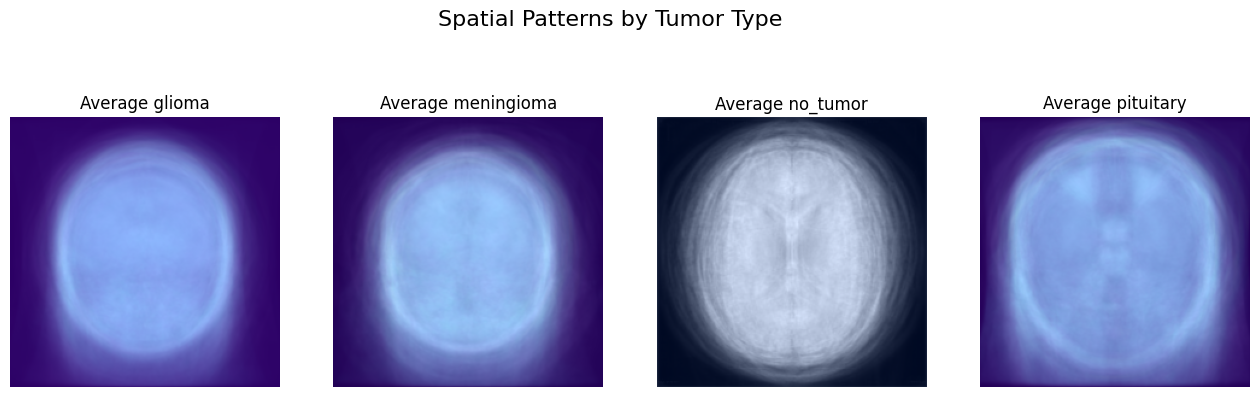

In [ ]:
def visualize_average_images(dataset, classes):
    """
    Computes and displays the average image for each class.
    """
    print("Computing average tumor patterns")
    class_sums = {c: torch.zeros(3, 224, 224) for c in range(len(classes))}
    class_counts = {c: 0 for c in range(len(classes))}

    # Use a subset of 2000 images for speed
    count = 0
    for img, label in dataset:
        class_sums[label] += img
        class_counts[label] += 1
        count += 1
        if count >= 2000: break

    plt.figure(figsize=(16, 5))
    for i, class_name in enumerate(classes):
        if class_counts[i] > 0:
            mean_img = class_sums[i] / class_counts[i]
            # Normalize to 0-1 for display
            mean_img = (mean_img - mean_img.min()) / (mean_img.max() - mean_img.min())
            np_img = mean_img.numpy().transpose(1, 2, 0)

            plt.subplot(1, 4, i + 1)
            plt.imshow(np_img)
            plt.title(f"Average {class_name}")
            plt.axis('off')

    plt.suptitle("Spatial Patterns by Tumor Type", fontsize=16)
    plt.show()

visualize_average_images(train_dataset, class_names)

In [ ]:
CUSTOM_CNN_PATH = 'custom_cnn_brain_tumor.pth'
train_custom = False #

#Custom CNN Architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Input: 3 x 224 x 224
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # 224 -> 112 -> 56 -> 28
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

custom_model = CustomCNN(len(class_names)).to("cpu")
if os.path.exists(CUSTOM_CNN_PATH) and not train_custom:
    print(f"Loading saved Custom CNN from {CUSTOM_CNN_PATH}...")
    custom_model.load_state_dict(torch.load(CUSTOM_CNN_PATH, map_location="cpu")) # Changed map_location
else:
    print("Training Custom CNN (30 Epochs)...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(custom_model.parameters(), lr=0.001)

    custom_epochs = 30
    custom_losses = []

    for epoch in range(custom_epochs):
        custom_model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to("cpu"), labels.to("cpu") # Changed to .to("cpu")
            optimizer.zero_grad()
            outputs = custom_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss/len(train_loader)
        custom_losses.append(avg_loss)
        print(f"Custom CNN Epoch [{epoch+1}/{custom_epochs}] Loss: {avg_loss:.4f}")

    torch.save(custom_model.state_dict(), CUSTOM_CNN_PATH)
    print("Custom CNN Saved!")



custom_model.eval()

Loading saved Custom CNN from custom_cnn_brain_tumor.pth...


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

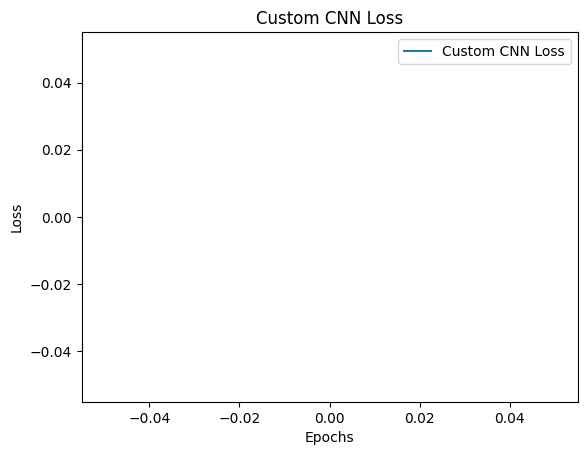

In [ ]:
plt.plot(custom_losses, label='Custom CNN Loss')
plt.title("Custom CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Colab_Models/resnet50_brain_tumor.pth'
FORCE_RETRAIN = False

def build_resnet50_model(num_classes):
    # Load pre-trained ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    #Transfer Learning
    for param in model.parameters():
        param.requires_grad = False

    # Modify the final layer for our 4 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model

#Initialize Model
model = build_resnet50_model(len(class_names))

#Check for Saved Model
if os.path.exists(MODEL_PATH) and not FORCE_RETRAIN:
    print(f"Found an existing model '{MODEL_PATH}'")
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    print("Model loaded successfully! Skipping training.")

else:
    print(" No saved model found. Starting training.")

    #Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    # Training Loop
    epochs = 10
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:


            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    print("Training Complete.")


Found an existing model '/content/drive/MyDrive/Colab_Models/resnet50_brain_tumor.pth'
Model loaded successfully! Skipping training.


In [ ]:
# Save the Model
torch.save(model.state_dict(), MODEL_PATH)
print(f"{MODEL_PATH}'")

/content/drive/MyDrive/Colab_Models/resnet50_brain_tumor.pth'


In [ ]:
# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.title("Transfer learning Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

NameError: name 'train_losses' is not defined

Model accuracy
ResNet50 Accuracy: 96.88%
Custom CNN Accuracy: 99.38%


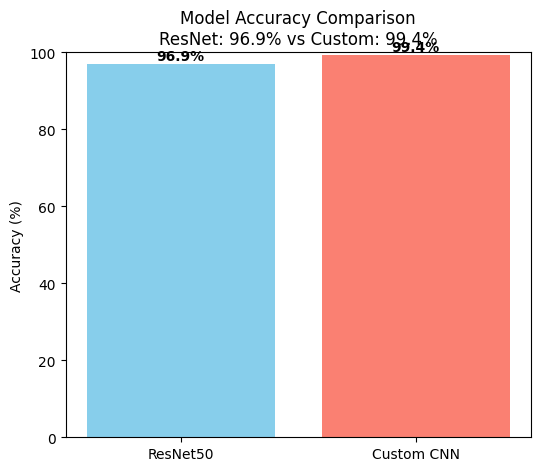

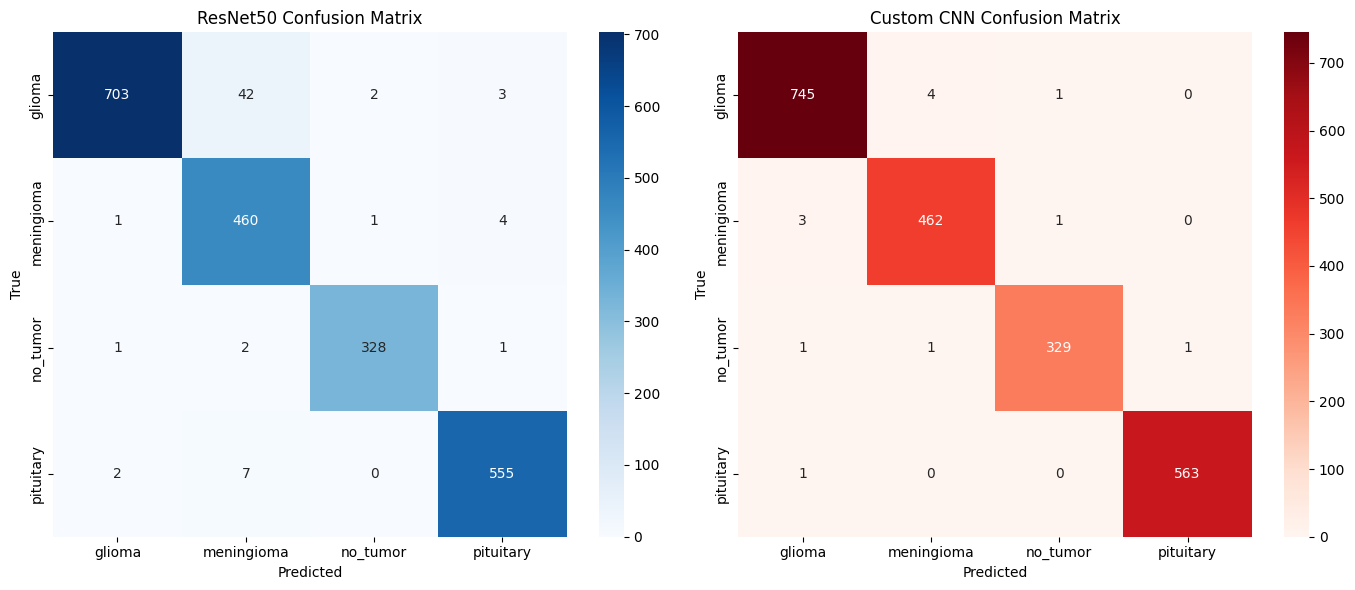

In [ ]:
def evaluate_model(model, loader, name):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * correct / total
    print(f"{name} Accuracy: {acc:.2f}%")
    return acc, all_labels, all_preds

print("Model accuracy")
resnet_acc, res_labels, res_preds = evaluate_model(model, test_loader, "ResNet50") #
custom_acc, cust_labels, cust_preds = evaluate_model(custom_model, test_loader, "Custom CNN")



#Bar Chart Comparison
plt.figure(figsize=(6, 5))
plt.bar(['ResNet50', 'Custom CNN'], [resnet_acc, custom_acc], color=['skyblue', 'salmon'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title(f'Model Accuracy Comparison\nResNet: {resnet_acc:.1f}% vs Custom: {custom_acc:.1f}%')
for i, v in enumerate([resnet_acc, custom_acc]):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

#Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(confusion_matrix(res_labels, res_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('ResNet50 Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(confusion_matrix(cust_labels, cust_preds), annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Custom CNN Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("\nResNet50 Classification Report:")
print(classification_report(res_labels, res_preds, target_names=class_names))


ResNet50 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       750
  meningioma       0.90      0.99      0.94       466
    no_tumor       0.99      0.99      0.99       332
   pituitary       0.99      0.98      0.98       564

    accuracy                           0.97      2112
   macro avg       0.97      0.97      0.97      2112
weighted avg       0.97      0.97      0.97      2112



In [ ]:
print("\nCustom CNN Classification Report:")
print(classification_report(cust_labels, cust_preds, target_names=class_names))


Custom CNN Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       750
  meningioma       0.99      0.99      0.99       466
    no_tumor       0.99      0.99      0.99       332
   pituitary       1.00      1.00      1.00       564

    accuracy                           0.99      2112
   macro avg       0.99      0.99      0.99      2112
weighted avg       0.99      0.99      0.99      2112

